In [131]:
import os
from pathlib import Path

import sys

import pandas as pd




In [137]:
multi_city_data = pd.read_csv("../data/india_pollution.csv", index_col=0)

multi_city_data.head()

PM2.5    PM10         O3         CO        SO2        NO2  \
Date                                                                    
2015-01-04  73.24  141.54  58.550000   5.247500  24.962500  17.922500   
2015-01-11  73.24  141.54  26.895714  71.757879  35.415714  33.014286   
2015-01-18  73.24  141.54  43.057143  19.975714  48.255714  28.844286   
2015-01-25  73.24  141.54  43.070000   7.854286  53.887143  24.790000   
2015-02-01  87.60  141.54  73.458571  14.118571  52.022857  28.014286   

             Latitude  Longitude       City  
Date                                         
2015-01-04  23.021624  72.579707  Ahmedabad  
2015-01-11  23.021624  72.579707  Ahmedabad  
2015-01-18  23.021624  72.579707  Ahmedabad  
2015-01-25  23.021624  72.579707  Ahmedabad  
2015-02-01  23.021624  72.579707  Ahmedabad

In [160]:
list_of_cities = multi_city_data.City.unique()
list_of_cities

array(['Ahmedabad', 'Bengaluru', 'Chennai', 'Delhi', 'Hyderabad',
       'Mumbai', 'Patna'], dtype=object)

In [161]:
# remove cities with less than 150 entries for PM2.5 in dataset
for city in list_of_cities:
    if len(multi_city_data[multi_city_data.City == city]) < 250:
        print(f"Removing {city} from list of cities")
        multi_city_data = multi_city_data[multi_city_data.City != city]
        list_of_cities = multi_city_data.City.unique()

print (f"Number of cities remaining in dataset: {len(multi_city_data.City.unique())}")
print(f" WHich are: {multi_city_data.City.unique()} and the list {list_of_cities}")

    

Number of cities remaining in dataset: 7
 WHich are: ['Ahmedabad' 'Bengaluru' 'Chennai' 'Delhi' 'Hyderabad' 'Mumbai' 'Patna'] and the list ['Ahmedabad' 'Bengaluru' 'Chennai' 'Delhi' 'Hyderabad' 'Mumbai' 'Patna']


In [140]:
import numpy as np

In [141]:
# pad out each city's data to be the same length
max_length = max([len(multi_city_data[multi_city_data.City == city]) for city in list_of_cities])
print(max_length)

for city in list_of_cities:
    city_data = multi_city_data[multi_city_data.City == city]
    if len(city_data) < max_length:
        print(f"Padding {city} to length {max_length}")
        city_data = city_data.append([city_data.iloc[-1]] * (max_length - len(city_data)))
        multi_city_data = multi_city_data[multi_city_data.City != city]
        multi_city_data = multi_city_data.append(city_data)


multi_city_data.head()


288
Padding Patna to length 288


PM2.5    PM10         O3         CO        SO2        NO2  \
2015-01-04  73.24  141.54  58.550000   5.247500  24.962500  17.922500   
2015-01-11  73.24  141.54  26.895714  71.757879  35.415714  33.014286   
2015-01-18  73.24  141.54  43.057143  19.975714  48.255714  28.844286   
2015-01-25  73.24  141.54  43.070000   7.854286  53.887143  24.790000   
2015-02-01  87.60  141.54  73.458571  14.118571  52.022857  28.014286   

             Latitude  Longitude       City  
2015-01-04  23.021624  72.579707  Ahmedabad  
2015-01-11  23.021624  72.579707  Ahmedabad  
2015-01-18  23.021624  72.579707  Ahmedabad  
2015-01-25  23.021624  72.579707  Ahmedabad  
2015-02-01  23.021624  72.579707  Ahmedabad

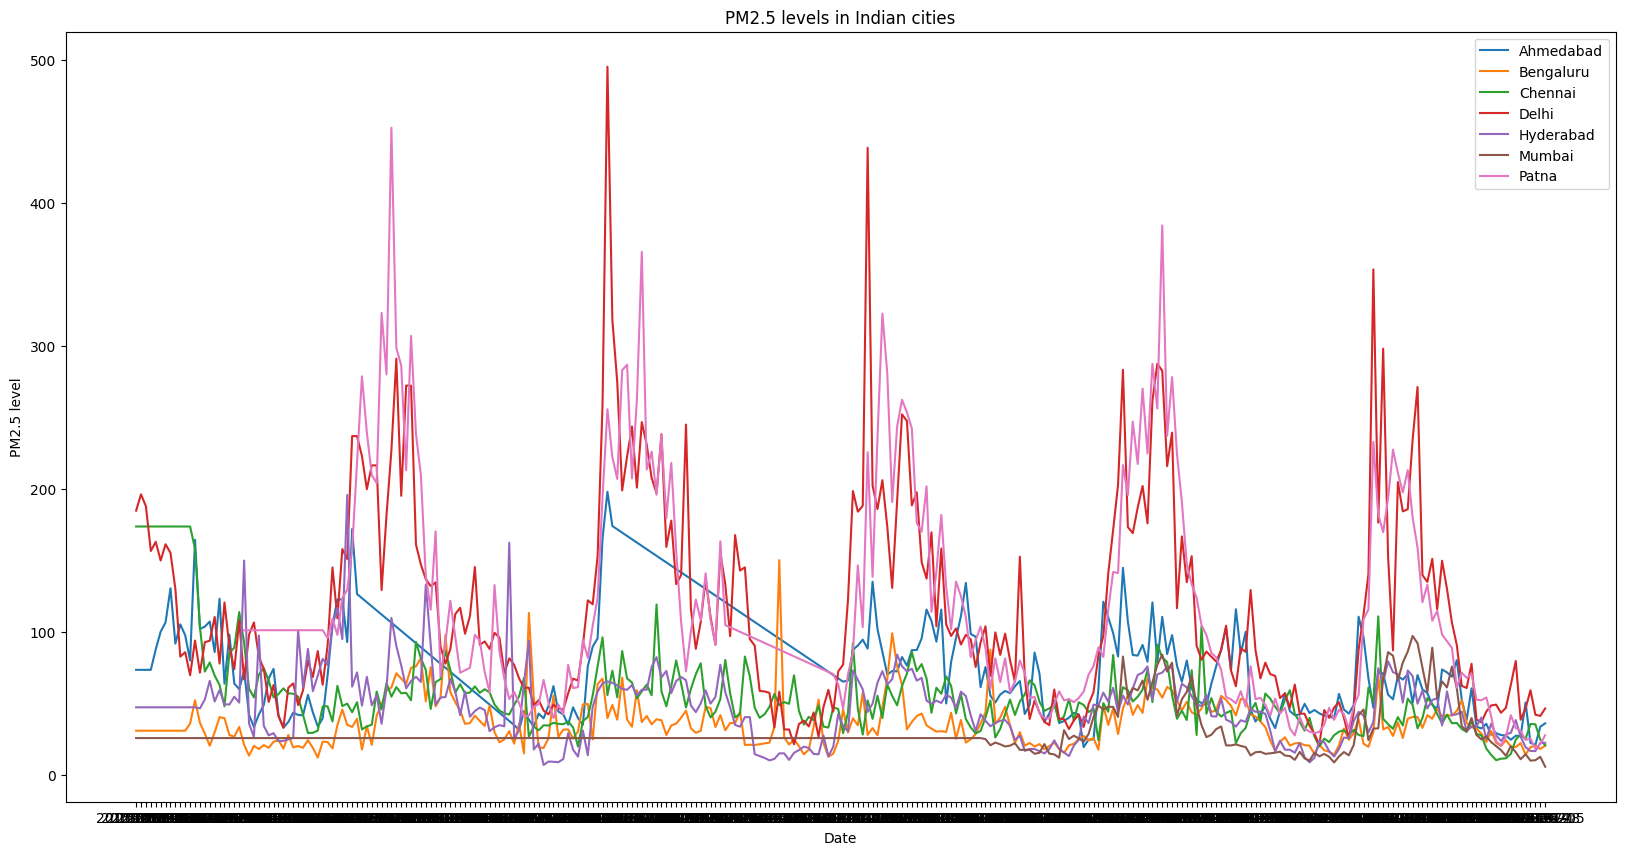

In [181]:
# Plot the padded data
import matplotlib.pyplot as plt




fig, ax = plt.subplots(figsize=(20, 10))
for city in list_of_cities:
    city_data = multi_city_data[multi_city_data.City == city]
    ax.plot(city_data.index, city_data["PM2.5"], label=city)
ax.legend()
ax.set_title("PM2.5 levels in Indian cities")
ax.set_xlabel("Date")
ax.set_ylabel("PM2.5 level")
plt.show()

In [143]:
# how many empty values are there in the dataset?
multi_city_data.isna().sum()

PM2.5        0
PM10         0
O3           0
CO           0
SO2          0
NO2          0
Latitude     0
Longitude    0
City         0
dtype: int64

In [144]:
variation_in_pm25 = np.vstack([multi_city_data[multi_city_data.City == city]["PM2.5"].values for city in list_of_cities])
# get rid of the first row of NaNs
variation_in_pm25 = variation_in_pm25[:, 1:]


variation_in_pm25.shape

(7, 287)

## Learning a graph structure

In [171]:
from sklearn import covariance

# fit a graphical lasso model to the data
# alphas are the regularization parameters, determined by cross validation
alphas = np.logspace(start=-1.5, stop=1.5, num=20)
edge_model = covariance.GraphicalLassoCV(alphas=alphas)



In [172]:
# standardize the time series: using correlations rather than covariance
# former is more efficient for structure recovery
X = variation_in_pm25.T
X /= X.std(axis=0)
edge_model.fit(X)

GraphicalLassoCV(alphas=array([ 0.03162278,  0.04548778,  0.06543189,  0.0941205 ,  0.13538762,
        0.1947483 ,  0.28013568,  0.40296113,  0.5796394 ,  0.83378222,
        1.19935395,  1.72521055,  2.48162892,  3.56969885,  5.13483291,
        7.38619982, 10.62467831, 15.28306733, 21.98392649, 31.6227766 ]))

## Clustering using affinity propagation

In [173]:
from sklearn import cluster

_, labels = cluster.affinity_propagation(edge_model.covariance_)
n_labels = labels.max()

for i in range(n_labels + 1):
    print(f"Cluster {i}: {list_of_cities[labels == i]}")

Cluster 0: ['Chennai']
Cluster 1: ['Ahmedabad' 'Bengaluru' 'Delhi' 'Hyderabad' 'Mumbai']
Cluster 2: ['Patna']


Text(0.5, 1.0, 'Average PM2.5 levels in Indian cities - clustering on time series structure')

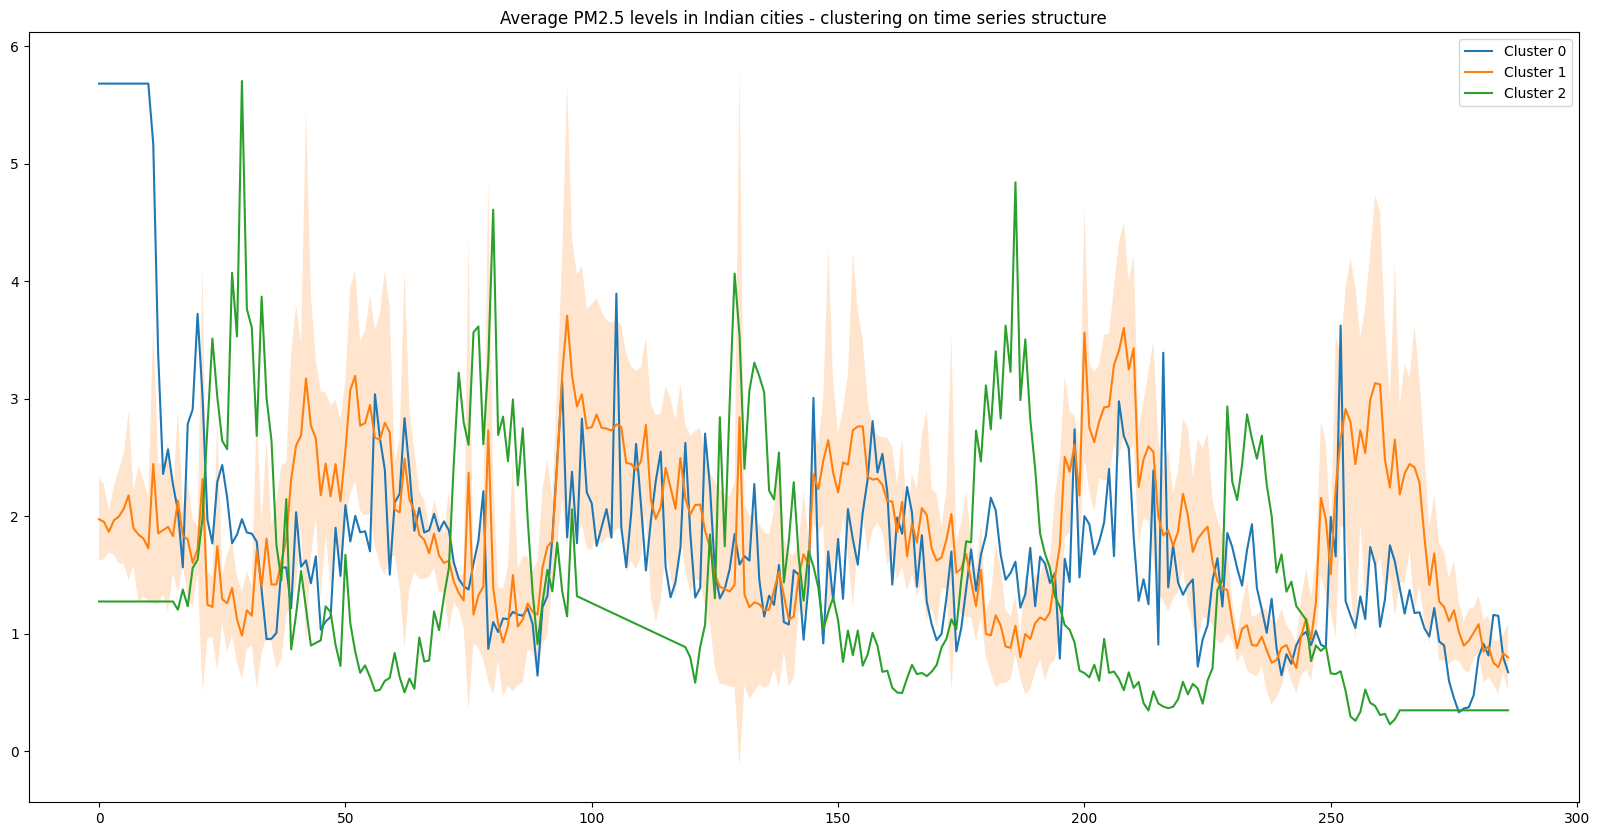

In [174]:
# plot the results - average PM2.5 per cluster
fig, ax = plt.subplots(figsize=(20, 10))
for i in range(n_labels + 1):
    ax.plot(variation_in_pm25[labels == i].mean(0), label=f"Cluster {i}")
    # add confidence intervals
    ax.fill_between(
        range(len(variation_in_pm25[labels == i].mean(0))),
        variation_in_pm25[labels == i].mean(0) - variation_in_pm25[labels == i].std(0),
        variation_in_pm25[labels == i].mean(0) + variation_in_pm25[labels == i].std(0),
        alpha=0.2,
    )
ax.legend()
ax.set_title("Average PM2.5 levels in Indian cities - clustering on time series structure") 


In [175]:
## CLuster lat longs using KMeans with uniform size clusters
from sklearn.cluster import KMeans

n_clusters = 3

kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(multi_city_data[["Latitude", "Longitude"]])

for i in range(n_clusters):
    print(f"Cluster {i}: {multi_city_data[kmeans.labels_ == i]['City'].mode().values}")

Cluster 0: ['Delhi' 'Patna']
Cluster 1: ['Bengaluru' 'Chennai' 'Hyderabad']
Cluster 2: ['Ahmedabad' 'Mumbai']


Northern most cluster is 0
Southern most cluster is 1
Cluster 0: ['Delhi' 'Patna']
Cluster 1: ['Bengaluru' 'Chennai' 'Hyderabad']
Cluster 2: ['Ahmedabad' 'Mumbai']


Text(0.5, 1.0, 'Average PM2.5 levels in Indian cities - clustering on geographical location')

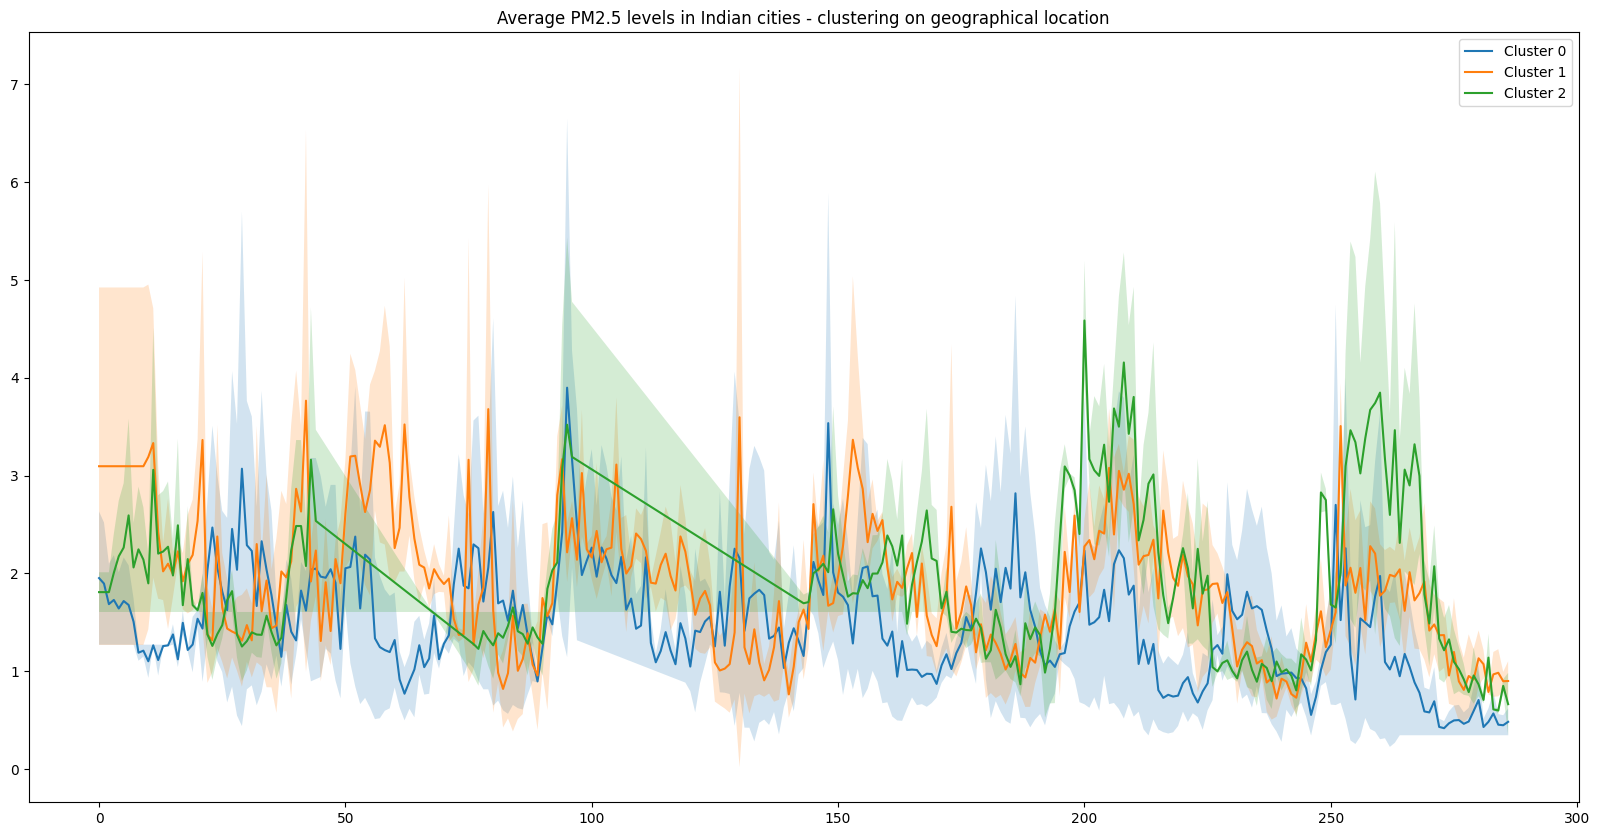

In [177]:
# plot the results - average PM2.5 per cluster - geographical
fig, ax = plt.subplots(figsize=(20, 10))

average_lat_long_per_cluster = multi_city_data.groupby(kmeans.labels_)[["Latitude", "Longitude"]].mean()
northern_most_cluster = average_lat_long_per_cluster["Latitude"].idxmax()
print(f"Northern most cluster is {northern_most_cluster}")
southern_most_cluster = average_lat_long_per_cluster["Latitude"].idxmin()
print(f"Southern most cluster is {southern_most_cluster}")


for i in range(n_clusters):
    cities_in = multi_city_data[kmeans.labels_ == i]["City"].mode().values
    print(f"Cluster {i}: {cities_in}")
    # avoid boolean index error
    if len(cities_in) == 0:
        continue
    ax.plot(
        variation_in_pm25[[city in cities_in for city in list_of_cities]].mean(0),
        label=f"Cluster {i}",
    )
    # add confidence intervals
    ax.fill_between(
        range(len(variation_in_pm25[[city in cities_in for city in list_of_cities]].mean(0))),
        variation_in_pm25[[city in cities_in for city in list_of_cities]].mean(0)
        - variation_in_pm25[[city in cities_in for city in list_of_cities]].std(0),
        variation_in_pm25[[city in cities_in for city in list_of_cities]].mean(0)
        + variation_in_pm25[[city in cities_in for city in list_of_cities]].std(0),
        alpha=0.2,
    )



ax.legend()
ax.set_title("Average PM2.5 levels in Indian cities - clustering on geographical location")

In [162]:
## Plot clusters on a map

import folium

# create a map of India
# india's lat long is 20.5937° N, 78.9629° E
india_map = folium.Map(location=[20, 80], zoom_start=4)

# add markers to map
for lat, lng, city in zip(multi_city_data["Latitude"], multi_city_data["Longitude"], multi_city_data["City"]):
    label = "{}".format(city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color="blue",
        fill=True,
        fill_color="#3186cc",
        fill_opacity=0.7,
        parse_html=False,
    ).add_to(india_map)

india_map


In [178]:
# Finding a low-dimension embedding for visualization: find the best position of
# the nodes (the cities) of the graph, which is a variant of the classical
# multi-dimensional scaling problem.

from sklearn import manifold

node_position_model = manifold.LocallyLinearEmbedding(
    n_components=2, eigen_solver="dense", n_neighbors=6
)

embedding = node_position_model.fit_transform(X.T).T

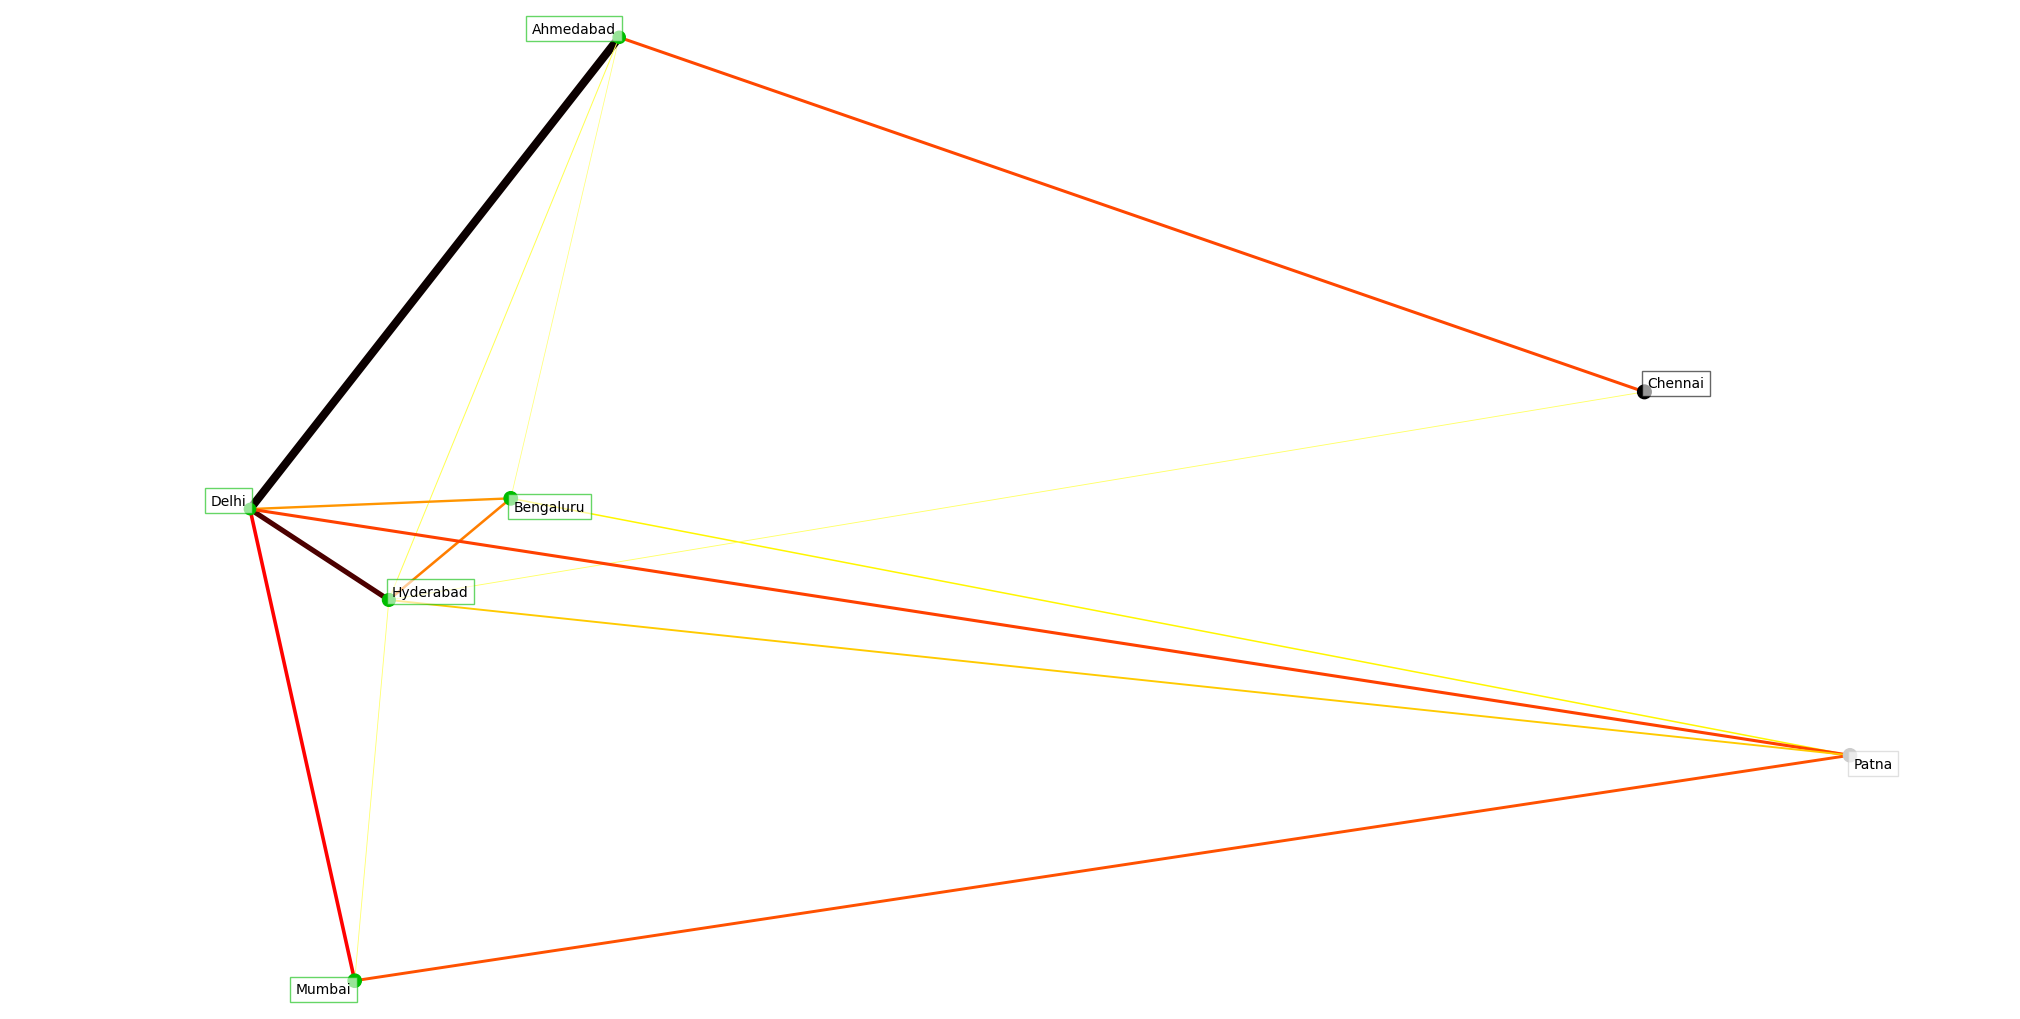

In [180]:
from matplotlib.collections import LineCollection

# visualize the nodes using the coordinates of our embedding

fig, ax = plt.subplots(figsize=(20, 10))

# Draw the nodes using the coordinates of our embedding


plt.figure(1, facecolor="w", figsize=(10, 8))
plt.clf()
ax = plt.axes([0.0, 0.0, 1.0, 1.0])
plt.axis("off")

# Plot the graph of partial correlations
partial_correlations = edge_model.precision_.copy()
d = 1 / np.sqrt(np.diag(partial_correlations))
partial_correlations *= d
partial_correlations *= d[:, np.newaxis]
non_zero = np.abs(np.triu(partial_correlations, k=1)) > 0.02

# Plot the nodes using the coordinates of our embedding
plt.scatter(
    embedding[0], embedding[1], s=100 * d**2, c=labels, cmap=plt.cm.nipy_spectral
)

# Plot the edges
start_idx, end_idx = np.where(non_zero)
# a sequence of (*line0*, *line1*, *line2*), where::
#            linen = (x0, y0), (x1, y1), ... (xm, ym)
segments = [
    [embedding[:, start], embedding[:, stop]] for start, stop in zip(start_idx, end_idx)
]
values = np.abs(partial_correlations[non_zero])
lc = LineCollection(
    segments, zorder=0, cmap=plt.cm.hot_r, norm=plt.Normalize(0, 0.7 * values.max())
)
lc.set_array(values)
lc.set_linewidths(15 * values)
ax.add_collection(lc)

# Add a label to each node. The challenge here is that we want to
# position the labels to avoid overlap with other labels
for index, (name, label, (x, y)) in enumerate(zip(list_of_cities, labels, embedding.T)):

    dx = x - embedding[0]
    dx[index] = 1
    dy = y - embedding[1]
    dy[index] = 1
    this_dx = dx[np.argmin(np.abs(dy))]
    this_dy = dy[np.argmin(np.abs(dx))]
    if this_dx > 0:
        horizontalalignment = "left"
        x = x + 0.002
    else:
        horizontalalignment = "right"
        x = x - 0.002
    if this_dy > 0:
        verticalalignment = "bottom"
        y = y + 0.002
    else:
        verticalalignment = "top"
        y = y - 0.002
    plt.text(
        x,
        y,
        name,
        size=10,
        horizontalalignment=horizontalalignment,
        verticalalignment=verticalalignment,
        bbox=dict(
            facecolor="w",
            edgecolor=plt.cm.nipy_spectral(label / float(n_labels)),
            alpha=0.6,
        ),
    )

plt.xlim(
    embedding[0].min() - 0.15 * embedding[0].ptp(),
    embedding[0].max() + 0.10 * embedding[0].ptp(),
)
plt.ylim(
    embedding[1].min() - 0.03 * embedding[1].ptp(),
    embedding[1].max() + 0.03 * embedding[1].ptp(),
)

plt.show()
